In [147]:

import json

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [148]:
metadata = open('../articles_data/all_articles_with_thumbnail_metadata.json')
papers = json.load(metadata)
#
# docs = [paper['article_title'] + ' ' + paper['abstract'] for paper in papers]
# doc_titles = [paper['article_title'] for paper in papers]
# doc_years = [paper['published_year'] for paper in papers]
#
#
# embeddings = model.encode(docs, show_progress_bar=True)


In [149]:
f = open(f'../embeddings/low_dimension/all_mpnet_base_v2_low_dim.json')
data = json.load(f)
doc_titles = data.keys()
embeddings = data.values()
doc_titles = list(doc_titles)
embeddings = list(embeddings)
docs = [paper['article_title'] + '. ' + paper['abstract'] for paper in papers]
doc_years = [paper['published_year'] for paper in papers]



In [150]:
from sklearn.cluster import DBSCAN


def cluster_docs():
    # umap_embeddings = umap.UMAP(n_neighbors=5,
    #                             n_components=2,
    #                             metric='cosine', random_state=42).fit_transform(embeddings)

    cluster = DBSCAN(eps=0.25, min_samples=2, metric='euclidean').fit(
        embeddings)

    # cluster = hdbscan.HDBSCAN(min_cluster_size=2,
    #                           metric='euclidean',
    #                           cluster_selection_method='eom').fit(umap_embeddings)
    # corpus_embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)
    # cluster = AgglomerativeClustering(affinity='cosine', linkage='average', distance_threshold=None, n_clusters=22).fit(corpus_embeddings) #, affinity='cosine', linkage='average', distance_threshold=0.4)

    # Prepare data
    # umap_data = umap.UMAP(n_neighbors=5, n_components=2, metric='euclidean', random_state=42).fit_transform(embeddings1)
    umap_data = embeddings
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    result['titles'] = doc_titles
    result['years'] = doc_years

    docs_df = pd.DataFrame(docs, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Titles'] = doc_titles
    docs_df['Years'] = doc_years
    docs_df['Yearsl'] = doc_years
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index=False).agg(
        {'Doc': ' '.join, 'Yearsl': list, 'Titles': len, 'Years': set})
    index = list(docs_per_topic.Years)
    years_topic_wise = {i - 1: list(index) for i, index in enumerate(index)}
    return result, cluster, docs_df, docs_per_topic, years_topic_wise

In [151]:


result, cluster, docs_df, docs_per_topic, years_topic_wise = cluster_docs()


In [152]:
def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [153]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))

In [154]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [words[j] for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [155]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                   .Doc
                   .count()
                   .reset_index()
                   .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                   .sort_values("Size", ascending=False))
    return topic_sizes

In [156]:
docs_per_topic

,Topic,Doc,Yearsl,Titles,Years
0,-1,Visual Exploratory Analysis for Multiple T-Maz...,"[2018, 2008, 2017, 2008, 2012, 2020, 2019, 201...",30,"{2014, 2020, 2019, 2016, 2017, 2018, 2015, 200..."
1,0,Interactive Exploded Views for Molecular Struc...,"[2019, 2017, 2016, 2020, 2016, 2019, 2017, 200...",13,"{2014, 2020, 2019, 2016, 2017, 2015, 2008}"
2,1,Layer-Aware iOCT Volume Rendering for Retinal ...,"[2019, 2008, 2019, 2010, 2010, 2016, 2008, 201...",10,"{2019, 2016, 2018, 2015, 2010, 2008}"
3,2,Introducing CNN-Based Mouse Grim Scale Analysi...,"[2018, 2021, 2020]",3,"{2018, 2020, 2021}"
4,3,Pelvis Runner: Visualizing Pelvic Organ Variab...,"[2019, 2016]",2,"{2016, 2019}"
5,4,VR Acrophobia Treatment - Development of Custo...,"[2020, 2020, 2018, 2020, 2020, 2015]",6,"{2015, 2020, 2018}"
6,5,CoWRadar: Visual Quantification of the Circle ...,"[2015, 2018, 2015, 2020, 2017, 2015, 2015]",7,"{2017, 2015, 2020, 2018}"
7,6,Atomistic Visualization of Mesoscopic Whole-Ce...,"[2012, 2015, 2014, 2020, 2019, 2016, 2015, 201...",9,"{2014, 2020, 2019, 2016, 2015, 2018, 2012}"
8,7,Multiparametric Magnetic Resonance Image Synth...,"[2019, 2019, 2020, 2017, 2017]",5,"{2017, 2020, 2019}"
9,8,Misalignment Correction in Open Cone-Beam CT. ...,"[2014, 2008, 2015, 2015]",4,"{2008, 2014, 2015}"


/Users/prush/opt/miniconda3/envs/doc_emb/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/var/folders/l5/wmvcg4v54jj1mdfc17dxh5rr0000gq/T/ipykernel_23927/2618364111.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l5/wmvcg4v54jj1mdfc17dxh5rr0000gq/T/ipykernel_23927/2618364111.py:71: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

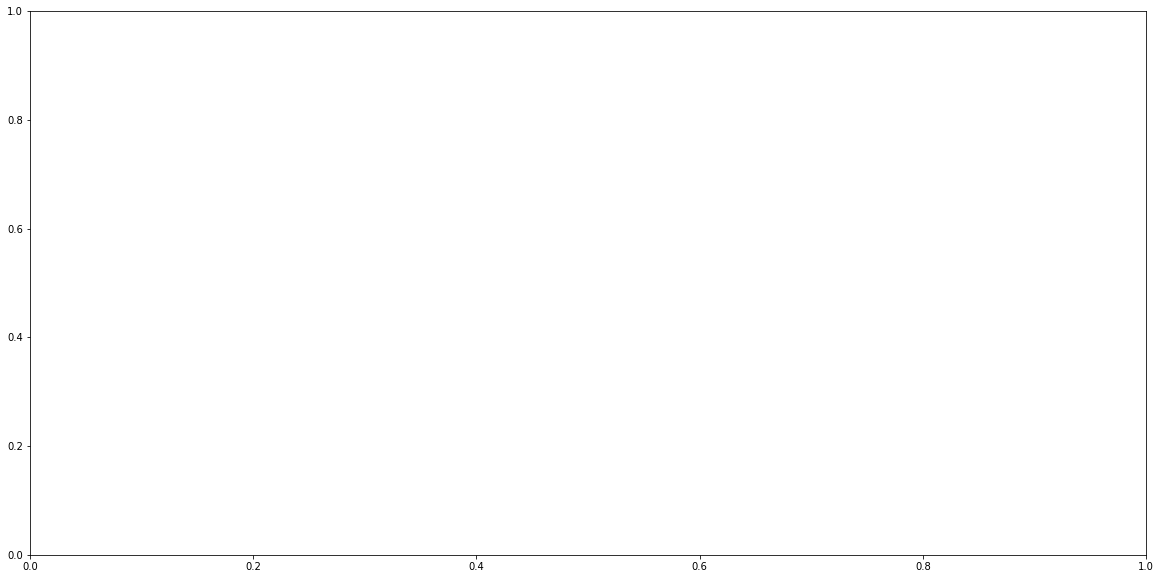

In [157]:


from matplotlib import pyplot as plt

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=8)

from collections import Counter
import plotly.graph_objects as go
import plotly.io as pio

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

# outlier_years = list(years_topic_wise[-1])
clustered_years = [value for key, value in years_topic_wise.items() if key != 1]

plot_top = Counter()
top_terms = top_n_words

num = []
for key, a in top_terms.items():
    k = []
    for i in a:
        for j in a:
            if i != j and i in j:
                k.append(i)

    r = list(filter(lambda i: i not in k, a))
    top_terms[key] = r

for b in clustered_years:
    k = b
    k = b.sort()

topic_years = ['.'.join(str(e) for e in years_topic_wise[item]) for item in clustered.labels]
topic_years_outliers = ['.'.join(str(e) for e in years_topic_wise[item]) for item in outliers.labels]

top_terms_docs = ['.'.join(str(e) for e in top_terms[item]) for item in clustered.labels]
top_terms_docs_outliers = ['.'.join(str(e) for e in top_terms[item]) for item in outliers.labels]

df1 = pd.DataFrame({'doc_terms_outliers': top_terms_docs_outliers, 'doc_years_outliers': topic_years_outliers})

df2 = pd.DataFrame({'doc_terms': top_terms_docs, 'doc_years': topic_years})

pio.renderers.default = "browser"
import plotly.express as px

color_discrete_sequence = ['#9a4979', '#62b9cc', '#117A65', '#de881f', '#CB4335',
                           '#c43f93', '#3dccd1', '#e07141', '#e041a0', '#0f00cd', '#ffa700', '#d62d20', '#008844',
                           '#72bd68', '#ba434f', '#48c2ba', '#e206cb', '#cfd63c', '#ca3bf9', '#bfc403', '#945edb',
                           '#ba0e37', '#9aa655', '#8e471b', '#473100',
                           '#fda025', '#21618C', '#6C3483', '#91ca1e', '#EB984E', '#239B56', '#1A5276',
                           'chocolate', 'aquamarine', 'blue',
                           'blueviolet', 'brown', 'cadetblue',
                           'chartreuse', 'coral', 'cornflowerblue', '#CD6155', '#873600']
# color_discrete_sequence = ['aliceblue', '#CD6155', 'aqua', 'aquamarine', 'blanchedalmond', 'blue',
#                            'blueviolet', 'brown', 'burlywood', 'cadetblue',
#                            'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
#                            'cornsilk', 'crimson', 'cyan', 'gold', 'goldenrod', 'green',
#                            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
#                            'ivory', 'khaki', 'lavender', 'lawngreen',
#                            '#945edb', '#e206cb', '#cfd63c',
#                            'linen', 'magenta',
#                            'mediumspringgreen',
#                            'mediumturquoise', 'mediumvioletred', 'midnightblue',
#                            'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy',
#                            'olive', 'olivedrab', 'orange',
#                            'orchid']

clustered['Publication Years'] = topic_years
clustered['Topic Words'] = top_terms_docs
clustered['Cluster Number'] = clustered.labels

fig = px.scatter(clustered, x='x', y='y', hover_name='titles', color='Topic Words',
                 # labels={"Topic Words" : "Topics"},
                 hover_data=['Publication Years', 'Cluster Number'], color_discrete_sequence=color_discrete_sequence)
fig.update_layout(legend=dict(title_font_family="Calibri",
                              font=dict(size=15), title="Topics"))

fig.add_trace(go.Scatter(x=outliers.x, y=outliers.y, customdata=df1, mode='markers', hovertext=outliers.titles,
                         name='outliers',
                         marker=dict(
                             color='#BDBDBD',
                         ),
                         hoverlabel=dict(
                             bgcolor="#ffffff",
                             font_size=12,
                             font_color="#141414",
                             font_family="Calibri",
                             bordercolor="#BDBDBD",
                         ),
                         hovertemplate='<b>%{hovertext}<br></b><br><br>Topic= %{customdata[0]}</br>Years = %{customdata[1]}<br>'
                         ))
fig.update_traces(textposition='top center')
fig.update_layout(
    margin=dict(l=5, r=5, b=30),
    xaxis_title='',
    yaxis_title='',
    xaxis=dict(
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    yaxis=dict(  # attribures for y axis
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    hoverlabel=dict(
        bgcolor="#ffffff",
        font_size=12,
        font_color="#141414",
        font_family="Calibri",
        bordercolor="#204ab3",
    ),
    plot_bgcolor='white',
)


In [158]:
top_n_words
mod = {}
for k, v in top_n_words.items():
    mod[k] = '.'.join(v)
topics = list(mod.values())
topics


['ct.colon.thermal.xr.mitral valve.automatic',
 'molecular.proteins.tunnels.molecules.properties.exploded',
 'parameterization.transfer function.texture.rendering.voxel model.volume visualization',
 'mgs.sleep staging.scoring.glaucoma.models.clinicians',
 'pelvis runner.clinical researchers.variability.anatomical changes.radiation therapy.stage',
 'vr.hand.student.reality.virtual.simulator.holographic.immersive',
 'cta.arteries.vessels.cow.cerebral artery.angiography',
 'molecular.mesoscopic.memory.molecule.large.cell.illumination.fibrils',
 'deep learning.mammogram.mg.supervised.classification.generative',
 'image registration.mean motion.motion model.lung.correction',
 'surface detection.growth.masks.sideness.stochastic.gradient.brain structures.pre treatment',
 'brain tumor.ius image.3d skeleton.convex ridges',
 'thems.multilinear model.fstt.medial.estimating.objects.skull',
 'connectivity.functional.neurons.eeg.coherence networks',
 'ray tracing.intensity focused.hifutk.focused ult

In [159]:
results_new = docs_per_topic.Yearsl.values
results_new = list(results_new)

all_years = ['2008', '2010', '2012', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
all_years_n = [2008, 2010, 2012, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

count_d = []
for k in results_new:
    resultn = []
    for year in all_years:
        if k.count(year) > 0:
            resultn.append(k.count(year))
        else:
            resultn.append(0)
    count_d.append(resultn)

print(count_d.pop(0))
D = pd.DataFrame(count_d)
D

[8, 0, 5, 3, 2, 1, 1, 2, 4, 3, 1]


,0,1,2,3,4,5,6,7,8,9,10
0,1,0,0,1,1,3,2,0,4,1,0
1,2,2,0,0,1,2,0,1,2,0,0
2,0,0,0,0,0,0,0,1,0,1,1
3,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,1,0,0,1,0,4,0
5,0,0,0,0,4,0,1,1,0,1,0
6,0,0,1,1,2,1,0,2,1,1,0
7,0,0,0,0,0,0,2,0,2,1,0
8,1,0,0,1,2,0,0,0,0,0,0
9,0,1,0,0,1,0,1,0,0,0,1


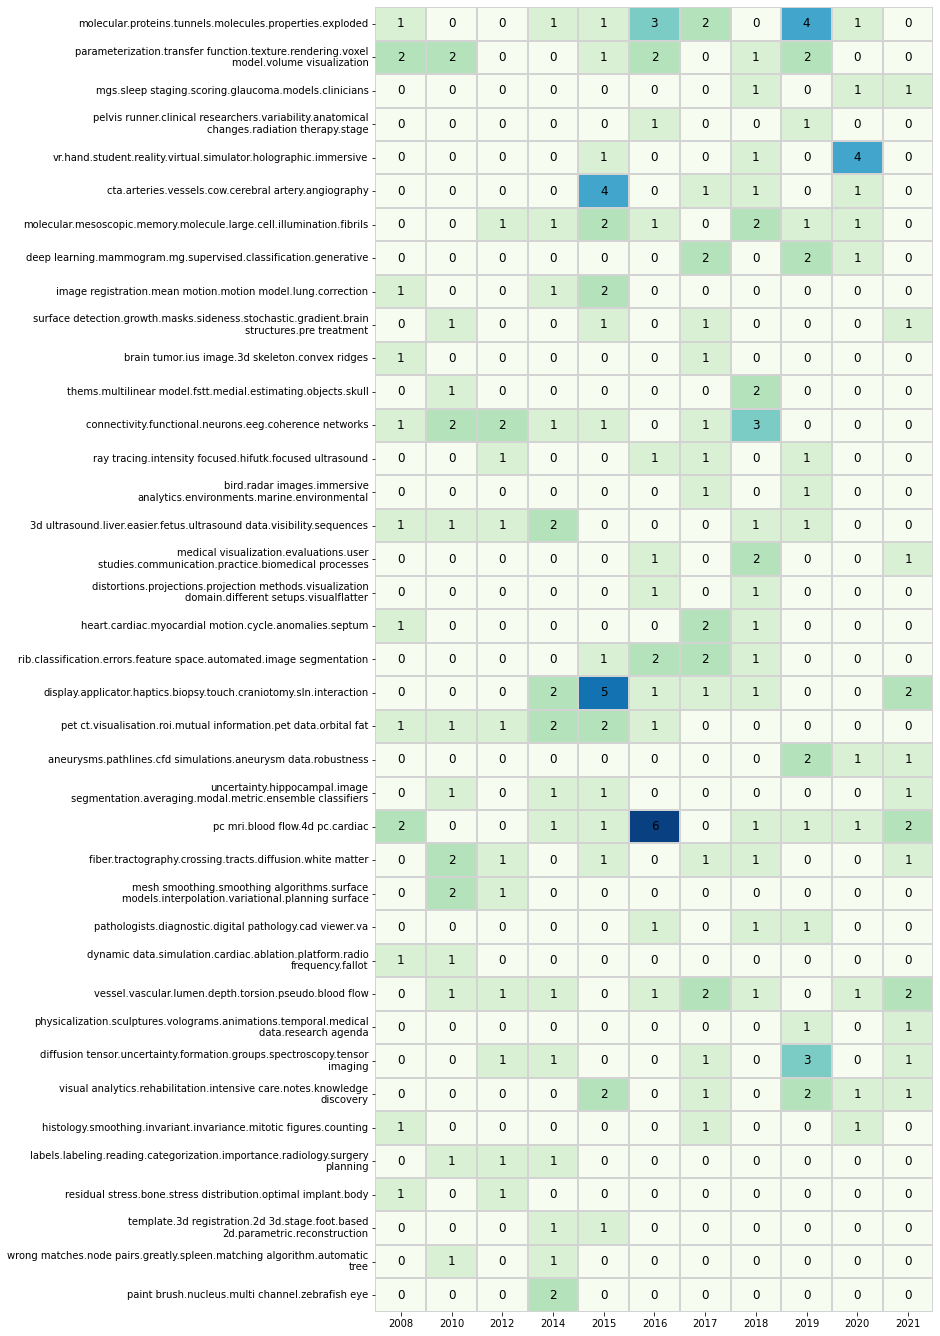

In [160]:
from textwrap import wrap
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 24))
# my_colors = ['#08c45b', '#eded72', '#926dd1']
topics.pop(0)
labels = ['\n'.join(wrap(l)) for l in topics]
ax = sns.heatmap(D, xticklabels=all_years, yticklabels=labels, annot=D,
                 cbar=False,
                 cmap='GnBu', ax=ax,
                 annot_kws={'fontsize': 12, 'color': 'Black', 'alpha': 1}, linewidths=0.08,
                 linecolor='lightgray',
                 )

NameError: name 'B' is not defined

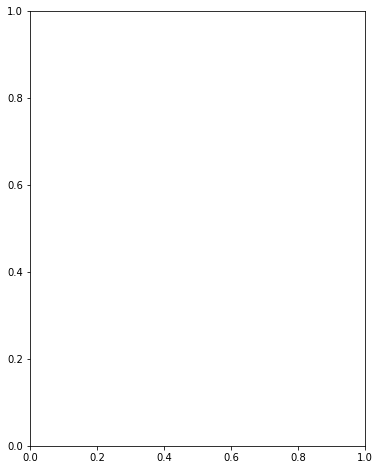

In [161]:


fig, ax = plt.subplots(figsize=(6, 8))
# my_colors = ['#08c45b', '#eded72', '#926dd1']
ax = sns.heatmap(B, xticklabels=model_names, yticklabels=labels, annot=A,
                 cbar_kws={'label': 'Publication Ranks',
                           'extend': 'max',
                           'ticks': [2, 4]},
                 cmap=my_cmap, vmin=1, vmax=4, cbar=True, ax=ax,
                 annot_kws={'fontsize': 12, 'color': 'black', 'alpha': 1}, linewidths=0.08,
                 linecolor='lightgray',
                 fmt='.4f')

In [ ]:


fig, ax = plt.subplots(figsize=(6, 6.6))
B = pd.DataFrame()
ax = sns.heatmap(B, xticklabels=model_names, yticklabels=labels, annot=A,
                 cbar_kws={'label': 'Number of articles',
                           'extend': 'max',
                           'ticks': [1, 2, 3]},
                 cmap=, vmin=1, vmax=3, cbar=True, ax=ax,
                 annot_kws={'fontsize': 12, 'color': 'black', 'alpha': 1}, linewidths=0.08,
                 linecolor='lightgray', fmt='.4f')
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([1.5, 2])
# colorbar.set_ticklabels(['1', '2'])
plt.show()

In [30]:


fig, ax = plt.subplots(figsize=(6, 6.6))
B = pd.DataFrame()
ax = sns.heatmap(B, xticklabels=model_names, yticklabels=labels, annot=A,
                 cbar_kws={'label': 'Number of articles',
                           'extend': 'max',
                           'ticks': [1, 2, 3]},
                 cmap=, vmin=1, vmax=3, cbar=True, ax=ax,
                 annot_kws={'fontsize': 12, 'color': 'black', 'alpha': 1}, linewidths=0.08,
                 linecolor='lightgray', fmt='.4f')
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([1.5, 2])
# colorbar.set_ticklabels(['1', '2'])
plt.show()

SyntaxError: invalid syntax (2522557939.py, line 9)

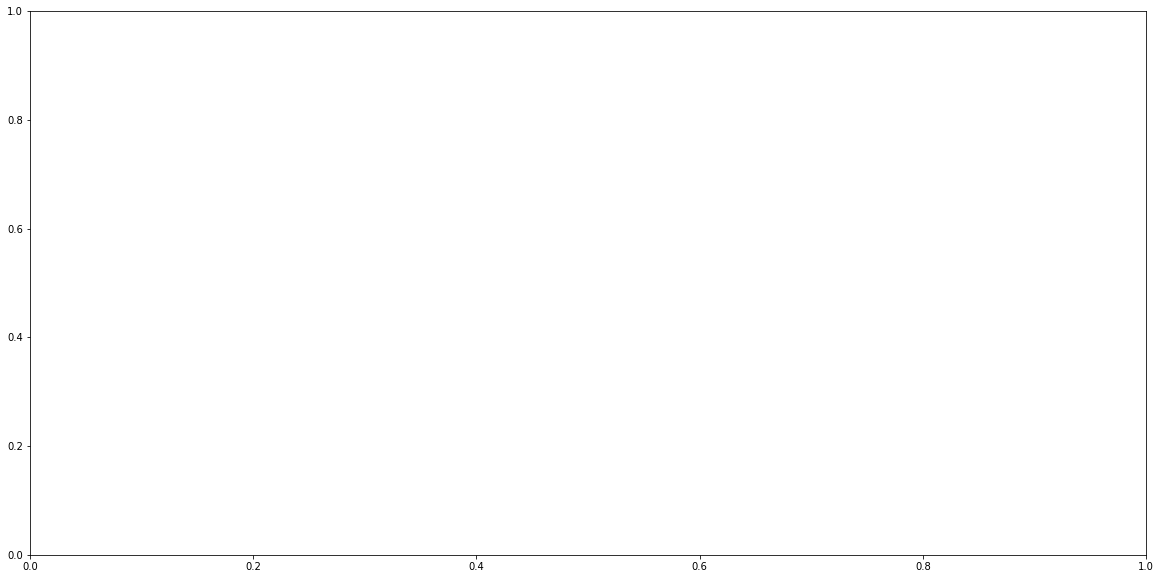

In [264]:


top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

import plotly.graph_objects as go
import plotly.io as pio

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

# outlier_years = list(years_topic_wise[-1])
clustered_years = [value for key, value in years_topic_wise.items() if key != 1]

plot_top = Counter()
top_terms = top_n_words

num = []
for key, a in top_terms.items():
    k = []
for i in a:
    for
j in a:
if i != j and i in j:
    k.append(i)

r = list(filter(lambda i: i not in k, a))
top_terms[key] = r

for b in clustered_years:
    k = b
k = b.sort()

topic_years = ['.'.join(str(e) for e in years_topic_wise[item]) for item in clustered.labels]
topic_years_outliers = ['.'.join(str(e) for e in years_topic_wise[item]) for item in outliers.labels]

top_terms_docs = ['.'.join(str(e) for e in top_terms[item]) for item in clustered.labels]
top_terms_docs_outliers = ['.'.join(str(e) for e in top_terms[item]) for item in outliers.labels]

df1 = pd.DataFrame({'doc_terms_outliers': top_terms_docs_outliers, 'doc_years_outliers': topic_years_outliers})

df2 = pd.DataFrame({'doc_terms': top_terms_docs, 'doc_years': topic_years})

pio.renderers.default = "browser"

color_discrete_sequence = ["#CD6155", '#9a4979', '#62b9cc', '#873600', '#117A65', '#de881f', '#CB4335',
                           '#c43f93', '#3dccd1', '#e07141', '#e041a0', '#0f00cd', '#ffa700', '#d62d20', '#008844',
                           '#72bd68', '#ba434f', '#48c2ba', '#945edb', '#e206cb', '#cfd63c', '#ca3bf9', '#bfc403',
                           '#ba0e37', '#9aa655', '#8e471b', '#473100',
                           '#fda025', '#21618C', '#6C3483', '#91ca1e', '#EB984E', '#239B56', '#1A5276']

clustered['Publication Years'] = topic_years
clustered['Topic Words'] = top_terms_docs
clustered['Cluster Number'] = clustered.labels
fig = px.scatter(clustered, x='x', y='y', hover_name='titles', color='Topic Words',
                 # labels={"Topic Words" : "Topics"},
                 hover_data=['Publication Years', 'Cluster Number'], color_discrete_sequence=color_discrete_sequence)

fig.add_trace(go.Scatter(x=outliers.x, y=outliers.y, customdata=df1, mode='markers', hovertext=outliers.titles,
                         name='outliers',
                         marker=dict(
                             color='#BDBDBD',
                         ),
                         hoverlabel=dict(
                             bgcolor="#ffffff",
                             font_size=12,
                             font_color="#141414",
                             font_family="Calibri",
                             bordercolor="#BDBDBD",
                         ),
                         hovertemplate='<b>%{hovertext}<br></b><br><br>Topic= %{customdata[0]}</br>Years = %{customdata[1]}<br>'
                         ))
fig.update_layout(
    margin=dict(l=5, r=5, b=30),
    xaxis_title='',
    yaxis_title='',
    xaxis=dict(
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    yaxis=dict(  # attribures for y axis
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    hoverlabel=dict(
        bgcolor="#ffffff",
        font_size=12,
        font_color="#141414",
        font_family="Calibri",
        bordercolor="#204ab3",
    ),
    plot_bgcolor='white',
)


In [478]:
# dis = top_n_words
# for k, v in dis.items():
#     i = ', '.join(v)
#     dis[k]=i
# dis

In [256]:
# yr =years_topic_wise
# for k, v in yr.items():
#     i = ', '.join(v)
#     yr[k]=i
# yr

['simulation', 'stress', 'blood vessels', 'mitral valve']


In [258]:
# result = {}
# for k, v in dis.items():
#     l = v + ' & ' + yr[k]
#     result[k] = l
# result

['simulation', 'stress', 'blood vessels', 'mitral valve']

In [ ]:
# c = [len(v) for v in top_terms.values()]
# print(min(c))
# for k, v in top_terms.items():
#     top_terms[k] = sample(v[::len(v) // min(c)], min(c))

